In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

# Data Preparation

In [ ]:
path = 'fashion-dataset/fashion-dataset/'
dataset_path = pathlib.Path(path)
dirs_names = os.listdir(dataset_path)
dirs_names

['styles', 'images', 'images.csv', 'styles.csv']

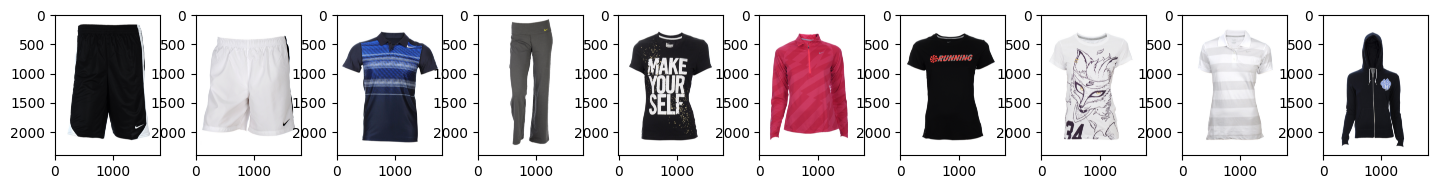

In [ ]:
# Plot samples
plt.figure(figsize=(20,20))
for i in range(20,30):
    plt.subplot(6, 10, i-10+1)
    cloth_img =  mpimg.imread(path + 'images/100' + str(i) +'.jpg') # Assigning images ids
    plt.imshow(cloth_img)
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

In [ ]:
styles_df = pd.read_csv(path + "styles.csv", nrows=6000, on_bad_lines='skip') # Reading 6000 product and drop bad lines using on_bad_lines='skip'
styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1)
print(styles_df.shape)
styles_df.head(5)

(6000, 11)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=styles_df)

https://docs.google.com/spreadsheets/d/1gfwPmLmprwNz2taEx_l_HXaJKgy1UUpQMHn3cTr4X6M#gid=0


/usr/local/lib/python3.10/dist-packages/google/colab/sheets.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return frame.applymap(_clean_val).replace({np.nan: None})


<Axes: ylabel='articleType'>

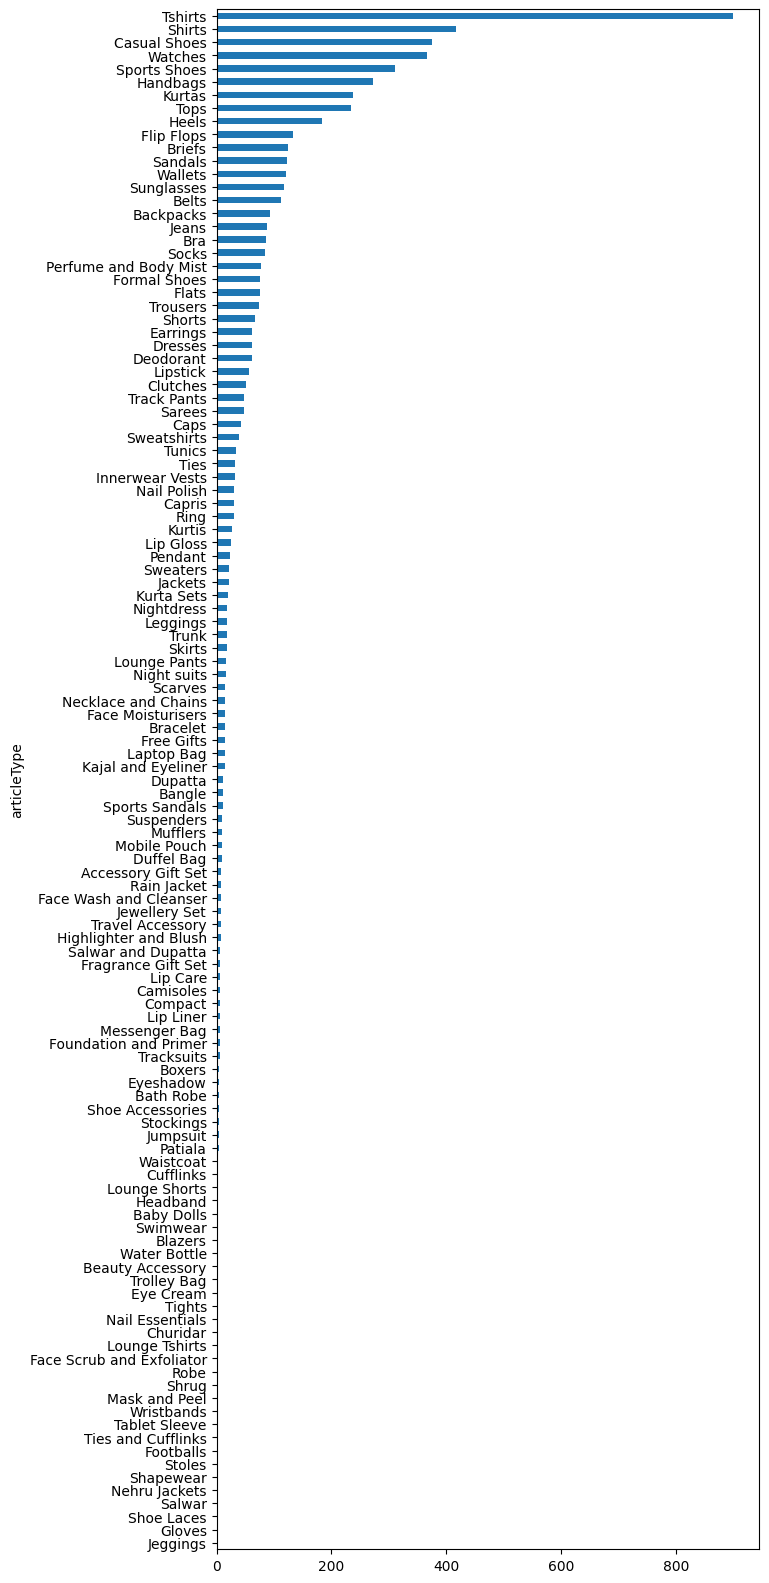

In [ ]:
plt.figure(figsize=(7,20))
styles_df.articleType.value_counts().sort_values().plot(kind='barh')

# Modeling and Get Image Embeddings

In [ ]:
#VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras import Sequential
import keras

img_width, img_height, chnls = 100, 100, 3

vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnls))
vgg16.trainable=False

# Create the Sequential model and add the input layer first
vgg16_model = Sequential()
vgg16_model.add(keras.Input(shape=(img_width, img_height, chnls))) # Add this line to define the input shape
vgg16_model.add(vgg16)
vgg16_model.add(GlobalMaxPooling2D())

vgg16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 3, 3, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 512)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
def img_path(img):
    """ Take image name(id) and return the complete path of it """
    return path + 'images/' + img

def predict(model, img_name):
    """ Load and preprocess image then make prediction """
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    img = image.img_to_array(img)
    # Expand Dim (1, w, h)
    img = np.expand_dims(img, axis=0)
    # Pre process Input
    img = preprocess_input(img)
    return model.predict(img)

In [ ]:
def get_embeddings(df, model):
    """ Return a dataframe contains images features """
    df_copy = df
    df_embeddings = df_copy['image'].apply(lambda x: predict(vgg16_model, x).reshape(-1))
    df_embeddings = df_embeddings.apply(pd.Series)
    return df_embeddings

df_embeddings = get_embeddings(styles_df, vgg16_model)

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━

In [ ]:
df_embeddings.head(5)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.000000,0.0,0.000000,0.0,0.143262,0.00000,0.000000,0.0,0.0,0.0,...,0.265156,3.163679,0.000000,0.000000,3.598499,0.094586,0.000000,0.000000,0.400017,3.075927
1,0.214865,0.0,0.642268,0.0,0.721051,0.00000,0.961315,0.0,0.0,0.0,...,0.972880,3.489842,0.444948,1.035509,4.321328,0.276158,0.657144,1.072055,0.752607,2.018364
2,1.869813,0.0,0.000000,0.0,0.445198,0.00000,0.000000,0.0,0.0,0.0,...,0.895740,0.185554,0.671141,0.076805,0.000000,0.400541,0.000000,0.000000,0.968235,0.000000
3,0.067576,0.0,0.000000,0.0,0.598626,0.00000,0.206587,0.0,0.0,0.0,...,1.043817,2.009501,0.382332,0.000000,1.067551,0.187985,0.000000,0.000000,0.145138,3.934349
4,0.000000,0.0,0.000000,0.0,0.090579,0.16434,0.000000,0.0,0.0,0.0,...,0.535294,0.341518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115650,1.671089


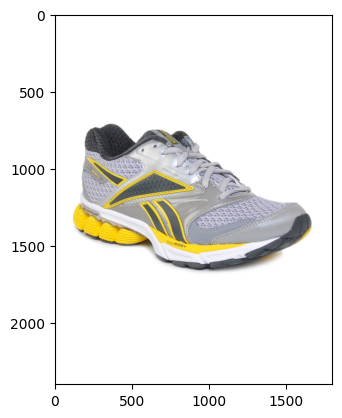

In [ ]:
url="fashion-dataset/fashion-dataset/images/10037.jpg"
a = plt.imread(url)
plt.imshow(a)

In [ ]:
sample_image = predict(vgg16_model, '10037.jpg')
sample_image.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


(1, 512)

In [ ]:
df_sample_image = pd.DataFrame(sample_image)
print(df_sample_image)

   0    1         2    3         4    5    6    7    8         9    ...  \
0  0.0  0.0  2.183094  0.0  0.782647  0.0  0.0  0.0  0.0  4.034313  ...   

        502      503       504  505       506       507       508       509  \
0  1.521103  0.21857  0.399624  0.0  3.021219  0.977197  0.112104  0.122217   

       510  511  
0  1.20951  0.0  

[1 rows x 512 columns]


In [ ]:
sample_similarity = linear_kernel(df_sample_image, df_embeddings)
print(sample_similarity)

[[317.70453 325.94382 309.251   ... 508.80466 347.53137 419.5999 ]]


In [ ]:
def get_similarity(model):
    """ Get similarity of custom image """
    sample_image = predict(vgg16_model, '10037.jpg')
    df_sample_image = pd.DataFrame(sample_image)
    sample_similarity = linear_kernel(df_sample_image, df_embeddings)
    return sample_similarity

In [ ]:
def normalize_sim(similarity):
    """ Normalize similarity results """
    x_min = similarity.min(axis=1)
    x_max = similarity.max(axis=1)
    norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
    return norm

sample_similarity_norm = normalize_sim(sample_similarity)
sample_similarity_norm.shape

(1, 6000)

In [ ]:
def get_recommendations(df, similarity):
    """ Return the top 5 most similar products """
    # Get the pairwsie similarity scores of all clothes with that one (index, value)
    sim_scores = list(enumerate(similarity[0]))

    # Sort the clothes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 5 most similar clothes
    sim_scores = sim_scores[0:5]
    print(sim_scores)
    # Get the clothes indices
    cloth_indices = [i[0] for i in sim_scores]

    # Return the top 5 most similar products
    return df['image'].iloc[cloth_indices]

[(855, 1.0), (2688, 0.94127107), (3886, 0.9183083), (709, 0.88677865), (5364, 0.8847835)]


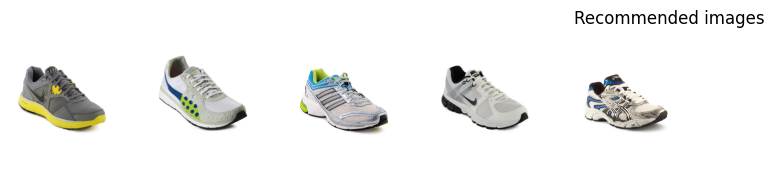

In [ ]:
recommendation = get_recommendations(styles_df, sample_similarity_norm)
recommendation_list = recommendation.to_list()
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("Recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

# Reusable class for production

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

class fashion_recommendations:
    """ Production class for recommendations of fashion from similarity """

    def __init__(self, img_path, df_embeddings, styles_path):
        self.img_path = img_path
        self.df_embeddings = df_embeddings
        self.styles_path = styles_path
    # Helper functions
    def get_styles_df(self):
        """ Load a dataframe contains styles details and images """
        styles_df = pd.read_csv(path + "styles.csv", nrows=6000, on_bad_lines='skip') # Read 6000 product and drop bad lines using on_bad_lines='skip'
        styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Make image column contains (id.jpg)
        return styles_df

    def load_model(self):
        """ Load our model """
        vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(100, 100, 3))
        vgg16.trainable=False
        vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
        return vgg16_model

    def predict(self, model, img_path):
        """ Load and preprocess image then make prediction """
        # Reshape
        img = image.load_img(self.img_path, target_size=(100, 100))
        # img to Array
        img = image.img_to_array(img)
        # Expand Dim (1, w, h)
        img = np.expand_dims(img, axis=0)
        # Pre process Input
        img = preprocess_input(img)
        return model.predict(img)

    def get_similarity(self):
        """ Get similarity of custom image """
        model = self.load_model()
        df_embeddings = self.df_embeddings
        sample_image = self.predict(model, self.img_path)
        df_sample_image = pd.DataFrame(sample_image)
        sample_similarity = linear_kernel(df_sample_image, df_embeddings)
        return sample_similarity

    def normalize_sim(self):
        """ Normalize similarity results """
        similarity = self.get_similarity()
        x_min = similarity.min(axis=1)
        x_max = similarity.max(axis=1)
        norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
        return norm

    def get_recommendations(self):
        """ Get recommended images """
        similarity = self.normalize_sim()
        df = self.get_styles_df()
        # Get the pairwsie similarity scores of all clothes with that one (index, value)
        sim_scores = list(enumerate(similarity[0]))

        # Sort the clothes based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 5 most similar clothes
        sim_scores = sim_scores[0:5]
        print(sim_scores)
        # Get the clothes indices
        cloth_indices = [i[0] for i in sim_scores]

        # Return the top 5 most similar products
        return df['image'].iloc[cloth_indices]

    def print_recommendations(self):
        """ Print the top 5 most similar products"""
        recommendation = self.get_recommendations()
        recommendation_list = recommendation.to_list()
        #recommended images
        plt.figure(figsize=(20,20))
        j=0
        for i in recommendation_list:
            plt.subplot(6, 10, j+1)
            cloth_img =  mpimg.imread("fashion-dataset/fashion-dataset/" + 'images/'+ i)
            plt.imshow(cloth_img)
            plt.axis("off")
            j+=1
        plt.title("Recommended images",loc='left')
        plt.subplots_adjust(wspace=-0.5, hspace=1)
        plt.show()
        return

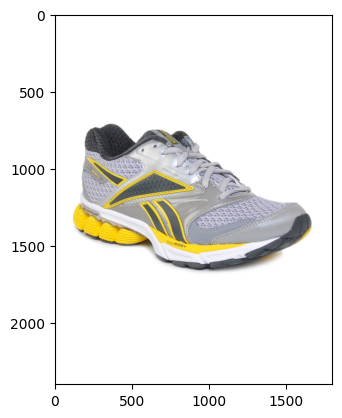

In [ ]:
url = "fashion-dataset/fashion-dataset/images/10037.jpg"
a = plt.imread(url)
plt.imshow(a)

In [ ]:
img_path = 'fashion-dataset/fashion-dataset/images/10037.jpg'
styles_path = 'fashion-dataset/fashion-dataset/styles.csv'
obj = fashion_recommendations(img_path, df_embeddings, styles_path)
obj.print_recommendations()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


TypeError: read_csv() got an unexpected keyword argument 'error_bad_lines'

In [ ]:
# prompt: give the code for deep learning using the same data

import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D, Dense, Flatten
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel
from google.colab import sheets
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras import Sequential
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you have already loaded styles_df and df_embeddings as in your previous code.

# Prepare data for deep learning
def prepare_data(df, img_width, img_height):
    X = []
    y = []
    for index, row in df.iterrows():
        try:
            img = image.load_img(path + 'images/' + row['image'], target_size=(img_width, img_height))
            img = image.img_to_array(img)
            X.append(img)
            y.append(row['articleType'])  # Assuming you want to predict articleType
        except Exception as e:
            print(f"Error processing image {row['image']}: {e}")
    X = np.array(X)
    y = pd.get_dummies(y)  # One-hot encode articleType
    return X, y

img_width, img_height, chnls = 100, 100, 3
X, y = prepare_data(styles_df, img_width, img_height)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Create the deep learning model
model = Sequential()
model.add(keras.Input(shape=(img_width, img_height, chnls)))
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# You can now use the trained model to predict the articleType for new images.


NameError: name 'styles_df' is not defined

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paramaggarwal/fashion-product-images-dataset
!unzip fashion-product-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: fashion-dataset/styles/58128.json  
  inflating: fashion-dataset/styles/58129.json  
  inflating: fashion-dataset/styles/5813.json  
  inflating: fashion-dataset/styles/58131.json  
  inflating: fashion-dataset/styles/58132.json  
  inflating: fashion-dataset/styles/58133.json  
  inflating: fashion-dataset/styles/58135.json  
  inflating: fashion-dataset/styles/58136.json  
  inflating: fashion-dataset/styles/58137.json  
  inflating: fashion-dataset/styles/58138.json  
  inflating: fashion-dataset/styles/58139.json  
  inflating: fashion-dataset/styles/5814.json  
  inflating: fashion-dataset/styles/58140.json  
  inflating: fashion-dataset/styles/58141.json  
  inflating: fashion-dataset/styles/58143.json  
  inflating: fashion-dataset/styles/58144.json  
  inflating: fashion-dataset/styles/58145.json  
  inflating: fashion-dataset/styles/58146.json  
  inflating: fashion-dataset/styles/58147.json  
  inflating: fashion